In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

# 从零开始的 NLP：使用序列到序列网络和注意力机制进行翻译
**作者**：[Sean Robertson](https://github.com/spro)

这是“从零开始的 NLP”系列教程的第三篇也是最后一篇，在这里我们将编写自己的类和函数来预处理数据，以执行我们的 NLP 建模任务。我们希望你完成这个教程后，会继续学习如何使用 `torchtext` 在接下来的三个教程中为你处理大部分这样的预处理工作。

在这个项目中，我们将教会神经网络从法语翻译成英语。

```sh
[键：> 输入, = 目标, < 输出]

> il est en train de peindre un tableau .
= he is painting a picture .
< he is painting a picture .

> pourquoi ne pas essayer ce vin delicieux ?
= why not try that delicious wine ?
< why not try that delicious wine ?

> elle n est pas poete mais romanciere .
= she is not a poet but a novelist .
< she not not a poet but a novelist .

> vous etes trop maigre .
= you re too skinny .
< you re all alone .
```
... 成功程度各有不同。

这得益于[序列到序列网络](https://arxiv.org/abs/1409.3215)_的简单但强大的理念，其中两个循环神经网络协同工作，将一个序列转换为另一个序列。一个编码器网络将输入序列压缩成一个向量，解码器网络将该向量展开成一个新序列。

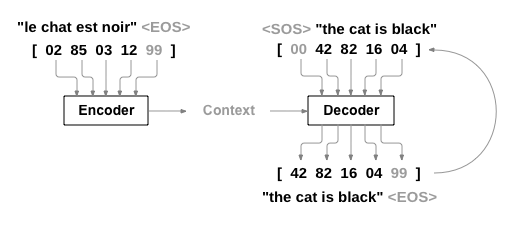

为了改进这个模型，我们将使用一个[注意力机制](https://arxiv.org/abs/1409.0473)_, 它允许解码器学习专注于输入序列的特定范围。

**推荐阅读：**

我假设你至少已经安装了 PyTorch，了解 Python，并且理解了张量：

-  https://pytorch.org/ 有关安装说明
-  :doc:`/beginner/deep_learning_60min_blitz` 开始了解 PyTorch 的基础
-  :doc:`/beginner/pytorch_with_examples` 对 PyTorch 有一个广泛而深入的概述
-  :doc:`/beginner/former_torchies_tutorial` 如果你是 Lua Torch 的前用户


了解序列到序列网络及其工作原理也会很有帮助：

-  [使用 RNN 编码器-解码器学习短语表示以进行统计机器翻译](https://arxiv.org/abs/1406.1078)_
-  [使用神经网络进行序列到序列学习](https://arxiv.org/abs/1409.3215)_
-  [通过联合学习对齐和翻译进行神经机器翻译](https://arxiv.org/abs/1409.0473)_
-  [神经会话模型](https://arxiv.org/abs/1506.05869)_

你还会发现之前的教程
:doc:`/intermediate/char_rnn_classification_tutorial`
和 :doc:`/intermediate/char_rnn_generation_tutorial`
很有帮助，因为这些概念与编码器和解码器模型非常相似。

**要求**

In [2]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import numpy as np
from torch.utils.data import TensorDataset, DataLoader, RandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 加载数据文件

这个项目的数据是由数千对英语到法语的翻译对组成的。

[Open Data Stack Exchange 上的这个问题](https://opendata.stackexchange.com/questions/3888/dataset-of-sentences-translated-into-many-languages)_ 指引我到了开放翻译网站 https://tatoeba.org/，该网站在 https://tatoeba.org/eng/downloads 提供下载 - 更好的是，有人做了额外的工作，将语言对分成了单独的文本文件，可在这里找到：https://www.manythings.org/anki/

英语到法语的对太大，无法包含在仓库中，因此请在继续之前下载到 ``data/eng-fra.txt``。该文件是一个用制表符分隔的翻译对列表：

```sh
I am cold.    J'ai froid.
```
<div class="alert alert-info"><h4>注意</h4><p>从
   [这里](https://download.pytorch.org/tutorial/data.zip)
   下载数据，并将其解压到当前目录。</p></div>



类似于在字符级 RNN 教程中使用的字符编码，我们将以一种语言中的每个单词表示为一个独热向量，或者说是一个除了一个位置为一（在该单词的索引处）其余都为零的巨大向量。与一种语言中可能存在的几十个字符相比，有更多的单词，因此编码向量要大得多。不过，我们会稍微作弊一下，只使用每种语言中的几千个单词来剪裁数据。

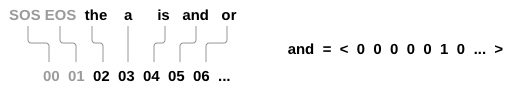




稍后我们需要为网络的输入和目标使用每个单词的唯一索引。为了跟踪所有这些，我们将使用一个名为 ``Lang`` 的辅助类，它具有单词→索引（``word2index``）和索引→单词（``index2word``）字典，以及每个单词的计数 ``word2count``，这将用于稍后替换罕见的单词。

In [3]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

The files are all in Unicode, to simplify we will turn Unicode
characters to ASCII, make everything lowercase, and trim most
punctuation.



In [4]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z!?]+", r" ", s)
    return s.strip()

为了读取数据文件，我们将文件分割成行，然后将行分割成对。这些文件都是英语 → 其他语言，所以如果我们想从其他语言 → 英语进行翻译，我添加了 ``reverse`` 标志来反转这些对。


In [5]:
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('../../data/nlp_scratch/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

由于有*很多*示例句子，而我们想要快速训练，我们将数据集裁剪为只包含相对短小和简单的句子。这里的最大长度是 10 个单词（包括结束标点符号），我们过滤出那些翻译成 "I am" 或 "He is" 等形式的句子（考虑到之前替换的撇号）。



In [6]:
MAX_LENGTH = 10

eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re "
)

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH and \
        p[1].startswith(eng_prefixes)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

准备数据的完整过程是：

-  读取文本文件并将其分割成行，将行分割成对
-  规范化文本，按长度和内容进行过滤
-  从对中的句子制作单词列表

In [7]:
def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

Reading lines...


Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991
['je ne suis plus inspiree', 'i m not inspired anymore']


## 序列到序列模型

循环神经网络（RNN）是一种在序列上操作，并使用自己的输出作为后续步骤输入的网络。

[序列到序列网络](https://arxiv.org/abs/1409.3215)_，或 seq2seq 网络，或[编码器解码器网络](https://arxiv.org/pdf/1406.1078v3.pdf)_，是由两个称为编码器和解码器的 RNN 组成的模型。编码器读取输入序列并输出单个向量，解码器读取该向量以产生输出序列。

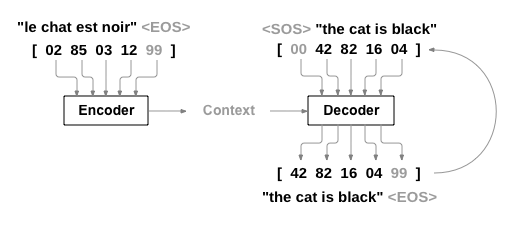

不同于使用单个 RNN 进行序列预测，其中每个输入对应一个输出，seq2seq 模型使我们摆脱了序列长度和顺序的束缚，这使它非常适合用于两种语言之间的翻译。

考虑句子 ``Je ne suis pas le chat noir`` → ``I am not the black cat``。输入句子中的大多数单词在输出句子中都有直接翻译，但顺序略有不同，例如 ``chat noir`` 和 ``black cat``。由于 ``ne/pas`` 构造，输入句子中还有一个多余的单词。直接从输入单词序列产生正确的翻译将是困难的。

在 seq2seq 模型中，编码器创建一个单一向量，理想情况下，该向量将输入序列的“含义”编码到单个向量中 —— 在某个 N 维句子空间中的某个点。

### 编码器

seq2seq 网络的编码器是一个 RNN，它为输入句子中的每个单词输出一些值。对于每个输入单词，编码器都会输出一个向量和一个隐藏状态，并使用这个隐藏状态作为下一个输入单词的处理基础。

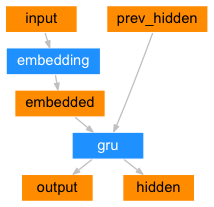





In [8]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_p=0.1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, input):
        embedded = self.dropout(self.embedding(input))
        output, hidden = self.gru(embedded)
        return output, hidden

### 解码器

解码器是另一个 RNN，它接收编码器的输出向量，并输出一系列单词来创建翻译。


#### 简单解码器

在最简单的 seq2seq 解码器中，我们只使用编码器的最后输出。这个最后的输出有时被称为*上下文向量*，因为它从整个序列中编码了上下文。这个上下文向量被用作解码器的初始隐藏状态。

在解码的每一步，解码器都会给定一个输入标记和隐藏状态。初始输入标记是字符串开始的``<SOS>``标记，第一个隐藏状态是上下文向量（编码器的最后一个隐藏状态）。

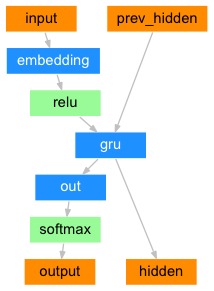

In [9]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden  = self.forward_step(decoder_input, decoder_hidden)
            decoder_outputs.append(decoder_output)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        return decoder_outputs, decoder_hidden, None # We return `None` for consistency in the training loop

    def forward_step(self, input, hidden):
        output = self.embedding(input)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        return output, hidden

I encourage you to train and observe the results of this model, but to
save space we'll be going straight for the gold and introducing the
Attention Mechanism.




### 注意力机制

如果只在编码器和解码器之间传递上下文向量，那么这个单一向量就要承载编码整个句子的负担。

注意力机制允许解码器网络在解码器自身输出的每一步上“关注”编码器输出的不同部分。首先，我们计算一组 *注意力权重*。这些权重将与编码器输出向量相乘，从而创建一个加权组合。结果（在代码中称为 `attn_applied`）应该包含关于输入序列的特定部分的信息，从而帮助解码器选择正确的输出词。

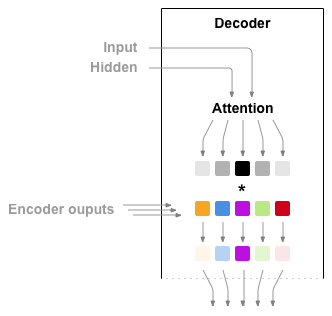

计算注意力权重是通过另一个前馈层 `attn` 完成的，使用解码器的输入和隐藏状态作为输入。由于训练数据中存在各种大小的句子，为了实际创建和训练这个层，我们必须选择一个最大句子长度（输入长度，用于编码器输出）来应用。最大长度的句子将使用所有的注意力权重，而较短的句子只会使用前几个。

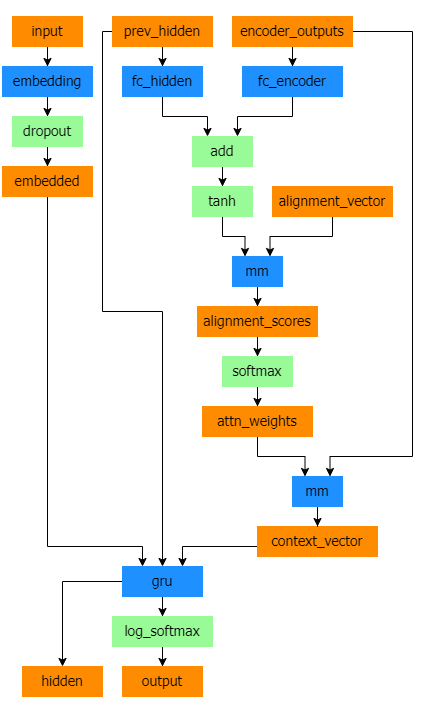

Bahdanau 注意力机制，也被称为加性注意力，是序列到序列模型中常用的注意力机制，特别是在神经机器翻译任务中。它由Bahdanau等人在他们的论文 [Neural Machine Translation by Jointly Learning to Align and Translate](https://arxiv.org/pdf/1409.0473.pdf) 中引入。该注意力机制利用了一个学习对齐模型来计算编码器和解码器隐藏状态之间的注意力得分。它利用一个前馈神经网络来计算对齐得分。

然而，还有其他可用的注意力机制，例如 Luong 注意力，它通过解码器隐藏状态和编码器隐藏状态之间的点积来计算注意力得分。它不涉及 Bahdanau 注意力中使用的非线性转换。

在本教程中，我们将使用 Bahdanau 注意力。但是，修改注意力机制以使用 Luong 注意力将是一项有价值的练习。

In [10]:
class BahdanauAttention(nn.Module):
    def __init__(self, hidden_size):
        super(BahdanauAttention, self).__init__()
        self.Wa = nn.Linear(hidden_size, hidden_size)
        self.Ua = nn.Linear(hidden_size, hidden_size)
        self.Va = nn.Linear(hidden_size, 1)

    def forward(self, query, keys):
        scores = self.Va(torch.tanh(self.Wa(query) + self.Ua(keys)))
        scores = scores.squeeze(2).unsqueeze(1)

        weights = F.softmax(scores, dim=-1)
        context = torch.bmm(weights, keys)

        return context, weights

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = BahdanauAttention(hidden_size)
        self.gru = nn.GRU(2 * hidden_size, hidden_size, batch_first=True)
        self.out = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(dropout_p)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor=None):
        batch_size = encoder_outputs.size(0)
        decoder_input = torch.empty(batch_size, 1, dtype=torch.long, device=device).fill_(SOS_token)
        decoder_hidden = encoder_hidden
        decoder_outputs = []
        attentions = []

        for i in range(MAX_LENGTH):
            decoder_output, decoder_hidden, attn_weights = self.forward_step(
                decoder_input, decoder_hidden, encoder_outputs
            )
            decoder_outputs.append(decoder_output)
            attentions.append(attn_weights)

            if target_tensor is not None:
                # Teacher forcing: Feed the target as the next input
                decoder_input = target_tensor[:, i].unsqueeze(1) # Teacher forcing
            else:
                # Without teacher forcing: use its own predictions as the next input
                _, topi = decoder_output.topk(1)
                decoder_input = topi.squeeze(-1).detach()  # detach from history as input

        decoder_outputs = torch.cat(decoder_outputs, dim=1)
        decoder_outputs = F.log_softmax(decoder_outputs, dim=-1)
        attentions = torch.cat(attentions, dim=1)

        return decoder_outputs, decoder_hidden, attentions


    def forward_step(self, input, hidden, encoder_outputs):
        embedded =  self.dropout(self.embedding(input))

        query = hidden.permute(1, 0, 2)
        context, attn_weights = self.attention(query, encoder_outputs)
        input_gru = torch.cat((embedded, context), dim=2)

        output, hidden = self.gru(input_gru, hidden)
        output = self.out(output)

        return output, hidden, attn_weights

<div class="alert alert-info"><h4>注意</h4><p>还有其他形式的注意力机制可以通过使用相对位置方法来解决长度限制的问题。请阅读《基于注意力的神经机器翻译的有效方法》中的“局部注意力”(https://arxiv.org/abs/1508.04025)。</p></div>

## 训练

### 准备训练数据

为了训练，对于每一对数据，我们需要一个输入张量（输入句子中单词的索引）和一个目标张量（目标句子中单词的索引）。在创建这些向量时，我们将在两个序列末尾添加 EOS 标记。


In [11]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def get_dataloader(batch_size):
    input_lang, output_lang, pairs = prepareData('eng', 'fra', True)

    n = len(pairs)
    input_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)
    target_ids = np.zeros((n, MAX_LENGTH), dtype=np.int32)

    for idx, (inp, tgt) in enumerate(pairs):
        inp_ids = indexesFromSentence(input_lang, inp)
        tgt_ids = indexesFromSentence(output_lang, tgt)
        inp_ids.append(EOS_token)
        tgt_ids.append(EOS_token)
        input_ids[idx, :len(inp_ids)] = inp_ids
        target_ids[idx, :len(tgt_ids)] = tgt_ids

    train_data = TensorDataset(torch.LongTensor(input_ids).to(device),
                               torch.LongTensor(target_ids).to(device))

    train_sampler = RandomSampler(train_data)
    train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    return input_lang, output_lang, train_dataloader

### 训练模型

为了进行训练，我们将输入句子通过编码器，同时保留每个输出和最新的隐藏状态。然后，将`<SOS>`标记作为解码器的第一个输入，并将编码器的最后隐藏状态作为其第一个隐藏状态。

"教师强制"是使用真实目标输出作为每个下一个输入的概念，而不是使用解码器的猜测作为下一个输入。使用教师强制可以加快收敛速度，但是当训练的网络被利用时，可能会出现不稳定的情况。

您可以观察到使用教师强制的网络的输出具有连贯的语法，但与正确的翻译相差甚远 - 直观上，它已经学会了表示输出语法，并且一旦教师告诉它前几个单词的意思，它就可以"理解"含义，但它并没有正确地学会如何从翻译中创建句子。

由于PyTorch的自动求导功能给了我们很大的自由度，我们可以使用简单的if语句随机选择是否使用教师强制。将`teacher_forcing_ratio`增加以使用更多的教师强制。

In [12]:
def train_epoch(dataloader, encoder, decoder, encoder_optimizer,
          decoder_optimizer, criterion):

    total_loss = 0
    for data in dataloader:
        input_tensor, target_tensor = data

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, _, _ = decoder(encoder_outputs, encoder_hidden, target_tensor)

        loss = criterion(
            decoder_outputs.view(-1, decoder_outputs.size(-1)),
            target_tensor.view(-1)
        )
        loss.backward()

        encoder_optimizer.step()
        decoder_optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

This is a helper function to print time elapsed and estimated time
remaining given the current time and progress %.




In [13]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

整个训练过程如下所示：

- 启动计时器
- 初始化优化器和损失函数
- 创建训练数据对集合
- 初始化用于绘图的空损失数组

然后我们多次调用`train`函数，并偶尔打印进度（示例的百分比、已耗时间、预计时间）和平均损失。


In [14]:
def train(train_dataloader, encoder, decoder, n_epochs, learning_rate=0.001,
               print_every=100, plot_every=100):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.Adam(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=learning_rate)
    criterion = nn.NLLLoss()

    for epoch in range(1, n_epochs + 1):
        loss = train_epoch(train_dataloader, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100, print_loss_avg))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### 绘制结果

绘图使用matplotlib完成，使用训练时保存的损失值数组`plot_losses`。


In [15]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

## 评估

评估大部分与训练相同，但是没有目标，因此我们只需将解码器的预测结果反馈回自身进行每一步。每次预测一个词语，我们将其添加到输出字符串中，如果预测到了EOS标记，我们就停止。我们还会存储解码器的注意力输出以供后续显示。


In [16]:
def evaluate(encoder, decoder, sentence, input_lang, output_lang):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)

        encoder_outputs, encoder_hidden = encoder(input_tensor)
        decoder_outputs, decoder_hidden, decoder_attn = decoder(encoder_outputs, encoder_hidden)

        _, topi = decoder_outputs.topk(1)
        decoded_ids = topi.squeeze()

        decoded_words = []
        for idx in decoded_ids:
            if idx.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            decoded_words.append(output_lang.index2word[idx.item()])
    return decoded_words, decoder_attn

We can evaluate random sentences from the training set and print out the
input, target, and output to make some subjective quality judgements:




In [17]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, _ = evaluate(encoder, decoder, pair[0], input_lang, output_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

## 训练和评估

通过所有这些辅助函数（看起来是多余的工作，但是这样做可以更容易地运行多个实验），我们实际上可以初始化一个网络并开始训练。

请记住，输入句子已经经过了严格的过滤。对于这个小数据集，我们可以使用相对较小的网络，包括256个隐藏节点和一个单独的GRU层。在MacBook的CPU上大约需要40分钟，我们将得到一些合理的结果。

<div class="alert alert-info"><h4>注意</h4><p>如果您运行此笔记本，您可以训练、中断内核、评估和稍后继续训练。请注释掉初始化编码器和解码器的行，并再次运行“trainIters”。</p></div>


In [18]:
hidden_size = 128
batch_size = 32

input_lang, output_lang, train_dataloader = get_dataloader(batch_size)

encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
decoder = AttnDecoderRNN(hidden_size, output_lang.n_words).to(device)

train(train_dataloader, encoder, decoder, 80, print_every=5, plot_every=5)

Reading lines...


Read 135842 sentence pairs
Trimmed to 11445 sentence pairs
Counting words...
Counted words:
fra 4601
eng 2991


/opt/anaconda3/envs/learning-in-general/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0m 9s (- 2m 23s) (5 6%) 1.5498
0m 19s (- 2m 13s) (10 12%) 0.6810
0m 28s (- 2m 2s) (15 18%) 0.3520
0m 37s (- 1m 53s) (20 25%) 0.1949
0m 46s (- 1m 43s) (25 31%) 0.1197
0m 55s (- 1m 33s) (30 37%) 0.0828
1m 4s (- 1m 23s) (35 43%) 0.0624
1m 13s (- 1m 13s) (40 50%) 0.0513
1m 22s (- 1m 4s) (45 56%) 0.0443
1m 32s (- 0m 55s) (50 62%) 0.0399
1m 41s (- 0m 46s) (55 68%) 0.0362
1m 50s (- 0m 36s) (60 75%) 0.0342
1m 59s (- 0m 27s) (65 81%) 0.0322
2m 9s (- 0m 18s) (70 87%) 0.0308
2m 18s (- 0m 9s) (75 93%) 0.0298
2m 27s (- 0m 0s) (80 100%) 0.0283


把dropout层 设置为 ``eval`` 模式



In [19]:
encoder.eval()
decoder.eval()
evaluateRandomly(encoder, decoder)

> elle est encore mineure
= she s still under age
< she is still a girl yet <EOS>

> vous n etes pas si interessante
= you re not that interesting
< you re not that interesting <EOS>

> tu es assise sur ma chaise
= you re sitting in my chair
< you re sitting in my chair <EOS>

> je suis en train de me concentrer
= i m concentrating
< i m concentrating <EOS>

> vous etes fiables
= you re reliable
< you re reliable <EOS>

> classer les choses n est pas mon fort
= i m not good at classifying things
< i m not good at classifying things <EOS>

> je me rejouis que tu te portes mieux
= i m glad you re doing better
< i m glad you re doing better <EOS>

> je suis fortunee
= i m wealthy
< i m wealthy yours <EOS>

> il est plus ruse que sage
= he is more crafty than wise
< he s more really smarter than me <EOS>

> je suis desole mais c est tout simplement impossible
= i m sorry but it s just not possible
< i m sorry but it s just not possible <EOS>



### 可视化注意力

注意机制的一个有用特性是其高度可解释的输出。由于它用于加权输入序列的特定编码器输出，我们可以想象在每个时间步骤中网络关注的位置。

您可以简单地运行`plt.matshow(attentions)`来将注意力输出显示为矩阵。为了获得更好的视觉体验，我们将额外添加坐标轴和标签:



In [20]:


def showAttention(input_sentence, output_words, attentions):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.cpu().numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)


    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(encoder, decoder, input_sentence, input_lang, output_lang)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions[0, :len(output_words), :])


evaluateAndShowAttention('il n est pas aussi grand que son pere')

evaluateAndShowAttention('je suis trop fatigue pour conduire')

evaluateAndShowAttention('je suis desole si c est une question idiote')

evaluateAndShowAttention('je suis reellement fiere de vous')

input = il n est pas aussi grand que son pere
output = he is not as tall as his father <EOS>
input = je suis trop fatigue pour conduire
output = i m too tired to drive you <EOS>
input = je suis desole si c est une question idiote
output = i m sorry if this is a stupid question <EOS>
input = je suis reellement fiere de vous
output = i m really proud of you <EOS>


/tmp/ipykernel_3764636/2136512848.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_3764636/2136512848.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/tmp/ipykernel_3764636/2136512848.py:17: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()
/tmp/ipykernel_3764636/2136512848.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_sentence.split(' ') +
/tmp/ipykernel_3764636/2136512848.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)
/t

## Exercises

-  Try with a different dataset

   -  Another language pair
   -  Human → Machine (e.g. IOT commands)
   -  Chat → Response
   -  Question → Answer

-  Replace the embeddings with pretrained word embeddings such as ``word2vec`` or
   ``GloVe``
-  Try with more layers, more hidden units, and more sentences. Compare
   the training time and results.
-  If you use a translation file where pairs have two of the same phrase
   (``I am test \t I am test``), you can use this as an autoencoder. Try
   this:

   -  Train as an autoencoder
   -  Save only the Encoder network
   -  Train a new Decoder for translation from there


